<a href="https://colab.research.google.com/github/ev1025/CS_Project4/blob/main/AI_15_%EC%9D%B4%EC%A7%84%EC%9A%B0_Section4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS_Project4 의류분류모델
- 패션은 단추, 문양이 하나만 바뀌어도 다른 옷이 된다. 이런 사소한 디테일 하나에 옷의 구매여부가 결정되기 때문에 다양한 특징을 잘 추출해서 좋은 옷을 추천해줄 수 있는 모델을 만들고자 한다.
- 패션 데이터들이 일단 크기가 방대하여 현재 기기로는 현실적으로 시도가 불가능했다. 일단 시도부터 해보자는 마음으로 fashion-mnist데이터로 분류모델을 만들었다.


# 가설
- 딥러닝모델을 이용해 의류분류모델을 만들 수 있다.



# 데이터 소개
**Fashion mnist**
- 다양한 기계 학습 시스템을 교육하고 테스트하는 데 일반적으로 사용되는 패션 이미지의 대규모 무료 데이터베이스입니다.

**각 라벨 별 아이템**
- 0 :티셔츠/탑
- 1 :바지
- 2 :풀오버
- 3 :드레스
- 4 :코트
- 5 :샌들
- 6 :셔츠
- 7 :스니커즈
- 8 :가방
- 9 :앵클 부츠




# 데이터 모델링

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install wandb

In [3]:
!wandb login 05b21e06d345e7c0e0fd77d3e16c1640326f1355

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import tensorflow.keras
import keras

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import wandb
from wandb.keras import WandbCallback

In [5]:
wandb_project = "deep_learn"

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
# 데이터 불러오기
(X_train,y_train),(X_test, y_test) = fashion_mnist.load_data()
print(f"X_train : {X_train.shape}, X_test : {X_test.shape}")

X_train : (60000, 28, 28), X_test : (10000, 28, 28)


In [8]:
# 모델 정규화(Softmax)
X_train = X_train / 255.
X_test = X_test /255.

In [9]:
# validation 분류
X_train,X_val, y_train,y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.25)
print(X_train.shape, X_val.shape)

(45000, 28, 28) (15000, 28, 28)


In [10]:
# 라벨 개수
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
wandb.init(project=wandb_project) 
wandb.config.epochs = 10
wandb.config.batch_size = 64

**CNN 모델 생성**

In [205]:
# 특징 추출을 위한 모델링

cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3),      
                     input_shape=(28,28,1), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3),      
                     input_shape=(28,28,1), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.3))

cnn_model.add(Flatten())
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(units=10, activation='softmax'))

In [206]:
cnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_21 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_22 (Bat  (None, 14, 14, 64)     

In [207]:
cnn_model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics='acc'
                  )

**체크포인트에 저장**

In [208]:
checkpoint_filepath = "cnn_1.hdf5"
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [209]:
cnn_best = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_loss',
    save_best_only = True,
    save_weight_only = True,
    mode = 'auto',
    save_freq='epoch'
)

In [210]:
cnn_1 = cnn_model.fit(X_train,y_train,
                      batch_size=wandb.config.batch_size,
                      epochs = wandb.config.epochs,
                      validation_data = (X_val, y_val),
                      callbacks=[early_stop, cnn_best, WandbCallback()]
                      )

Epoch 1/10
704/704 [==============================] - 7s 7ms/step - loss: 0.6002 - acc: 0.7851 - val_loss: 0.4735 - val_acc: 0.8261
Epoch 2/10
704/704 [==============================] - 5s 7ms/step - loss: 0.4130 - acc: 0.8491 - val_loss: 0.3370 - val_acc: 0.8846
Epoch 3/10
704/704 [==============================] - 5s 7ms/step - loss: 0.3666 - acc: 0.8670 - val_loss: 0.3274 - val_acc: 0.8857
Epoch 4/10
704/704 [==============================] - 4s 6ms/step - loss: 0.3297 - acc: 0.8788 - val_loss: 0.2795 - val_acc: 0.8976
Epoch 5/10
704/704 [==============================] - 4s 6ms/step - loss: 0.3189 - acc: 0.8822 - val_loss: 0.2749 - val_acc: 0.9009
Epoch 6/10
704/704 [==============================] - 5s 7ms/step - loss: 0.3074 - acc: 0.8858 - val_loss: 0.2846 - val_acc: 0.8996
Epoch 7/10
704/704 [==============================] - 4s 6ms/step - loss: 0.2892 - acc: 0.8945 - val_loss: 0.2954 - val_acc: 0.8991
Epoch 8/10
699/704 [============================>.] - ETA: 0s - loss: 0.2815

wandb: Adding directory to artifact (/content/wandb/run-20230317_074239-7e4tloqe/files/model-best)... Done. 0.0s


704/704 [==============================] - 6s 9ms/step - loss: 0.2810 - acc: 0.8985 - val_loss: 0.2621 - val_acc: 0.9090
Epoch 9/10
704/704 [==============================] - 6s 8ms/step - loss: 0.2769 - acc: 0.8989 - val_loss: 0.2750 - val_acc: 0.9071
Epoch 10/10
704/704 [==============================] - 4s 6ms/step - loss: 0.2673 - acc: 0.9023 - val_loss: 0.2959 - val_acc: 0.9013


In [211]:
cnn_model.load_weights(checkpoint_filepath)

**90% 이상의 분류 정확도를 얻었다.**

In [212]:
cnn_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2826 - acc: 0.9061


[0.28258606791496277, 0.9060999751091003]

In [213]:
y_pred = cnn_model.predict(X_test).round(2)
y_pred_label = list(map(np.argmax, y_pred))

313/313 [==============================] - 1s 2ms/step


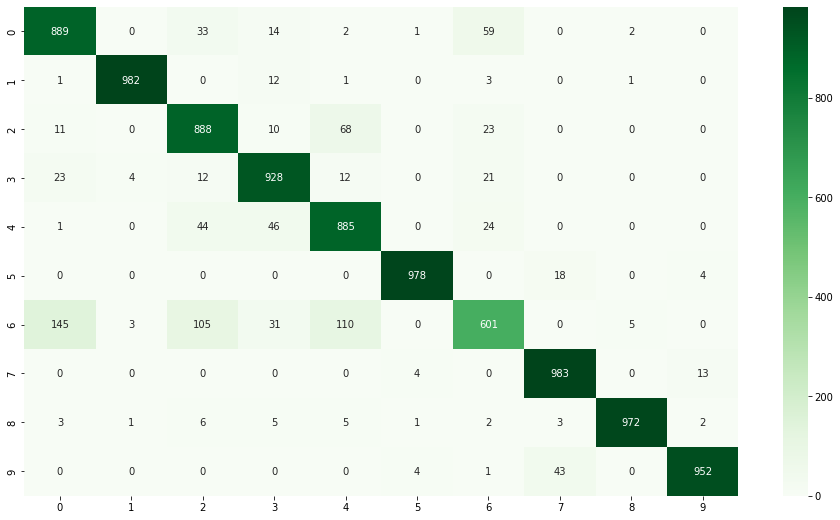

In [214]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (16,9))

cm = confusion_matrix(y_test,y_pred_label)

sns.heatmap(cm , annot = True,fmt = 'd',cmap='Greens')
plt.show();

**오차율, 정확도 그래프**

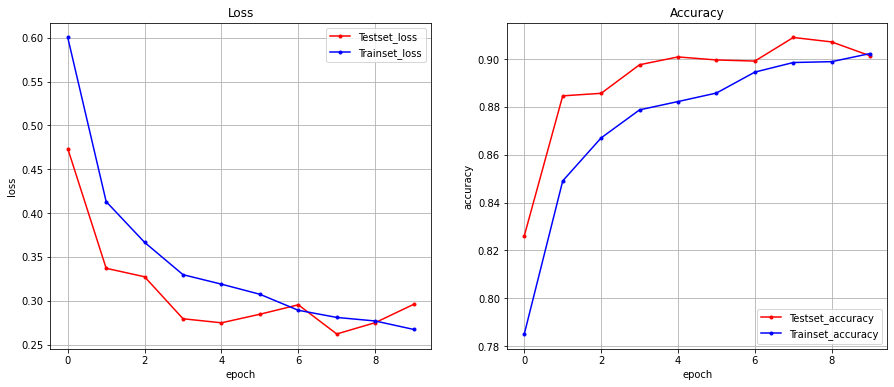

In [215]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))

# 오차
y_loss = cnn_1.history['loss']
y_vloss = cnn_1.history['val_loss']

# 정확도
y_accuracy = cnn_1.history['acc']
y_vaccuracy = cnn_1.history['val_acc']

# 오차그래프
x_len = np.arange(len(y_loss))
ax1.plot(x_len, y_vloss, marker = '.', c="red", label='Testset_loss')
ax1.plot(x_len, y_loss, marker = '.', c='blue', label = 'Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
ax1.legend(loc='upper right')
ax1.grid()
ax1.set(xlabel='epoch', ylabel='loss', title='Loss')

# 정확도 그래프
x_len = np.arange(len(y_accuracy))
ax2.plot(x_len, y_vaccuracy, marker = '.', c="red", label='Testset_accuracy')
ax2.plot(x_len, y_accuracy, marker = '.', c='blue', label = 'Trainset_accuracy')

# 그래프에 그리드를 주고 레이블을 표시
ax2.legend(loc='lower right')
ax2.grid()

ax2.set(xlabel='epoch', ylabel='accuracy', title='Accuracy')

# draw gridlines
ax2.grid(True)
plt.show()

**훈련데이터, 평가데이터 라벨링**

In [216]:
# train 라벨
label_train = y_train
label_train = pd.DataFrame(label_train)
label_train = label_train.replace(0,'Top').replace(1,'pant').replace(2,'pullover').replace(3,'dress').replace(4,'coat').replace(5,'Sandals').replace(6,'Shirt').replace(7,'Sneaker').replace(8,'Bag').replace(9,'Ankle Boots')

# test 라벨
label_test = y_test
label_test = pd.DataFrame(label_test)
label_test = label_test.replace(0,'Top').replace(1,'pant').replace(2,'pullover').replace(3,'dress').replace(4,'coat').replace(5,'Sandals').replace(6,'Shirt').replace(7,'Sneaker').replace(8,'Bag').replace(9,'Ankle Boots')

# 목록
labels = ['TOP','Pants','Pullover','Dress','Coat','Sandals','Shirt','Sneaker','Bag','Ankle Boots']
labels = pd.DataFrame(labels)
labels

,0
0,TOP
1,Pants
2,Pullover
3,Dress
4,Coat
5,Sandals
6,Shirt
7,Sneaker
8,Bag
9,Ankle Boots


**샘플데이터를 정규화**

In [217]:
# 샘플 데이터 불러오기
deep_dir = '/content/drive/MyDrive/코드스테이츠/프로젝트/프로젝트4/의류 샘플'
files = os.listdir(deep_dir)
len(files)

16

In [218]:
# rgb데이터를 흑백으로 변경(mnist는 1차원이기 때문에 기본사진의 3차원을 1차원으로 변경해주어야함)
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [219]:
# 이미지 함수
def image_maker(file):
    image_path = deep_dir+'/'+file
    image =  tf.keras.utils.load_img(image_path)
    return image

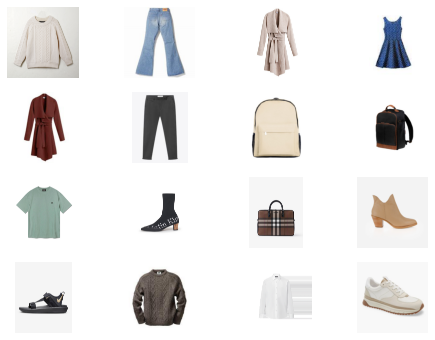

In [220]:
# 샘플데이터
j = 1
plt.figure(figsize=(8,6))

for file in files:
    image = image_maker(file)
    plt.subplot(4,4,j); 
    j+=1
    plt.imshow(image, cmap = 'Greys')
    plt.axis('off')   
plt.show();

In [221]:
# 샘플데이터를 분류하는 모델
def load_and_preprocessing(base_dir, name, model):

    image_path = base_dir+'/'+name
    image =  tf.keras.utils.load_img(image_path, target_size=(28,28))
    input_arr = tf.keras.utils.img_to_array(image) / 255.
    input_arr = rgb2gray(input_arr)

    global j
    plt.subplot(4,4,j); 
    j+=1
    plt.imshow(input_arr, cmap = 'Greys')
    plt.axis('off')
    
    input_arr = np.array([input_arr])
    predictions = model.predict(input_arr)
    predict_class = np.argmax(predictions, axis=1) 

    plt.title(f"Real : {name}\nPredict:{labels.iloc[predict_class[0]][0]}")
    

    return predict_class[0]

1/1 [==============================] - 0s 32ms/step


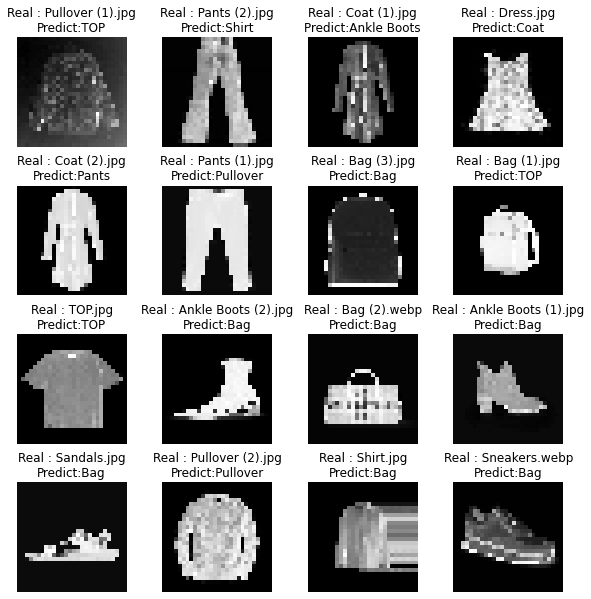

In [222]:
# 실제로 여러 샘플을 가지고 분석해본 결과 예측률이 현저히 낮았다.
plt.figure(figsize=(10,7))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=1.2, wspace=0.2, hspace=0.35)
j = 1
predict_class = [load_and_preprocessing(deep_dir, filename, cnn_model) for filename in files]
plt.show();

# 프로젝트 결과 및 회고

**프로젝트 결과 및 회고**
- 의류분류 정확도가 90%가 넘는 모델을 만들었다.
- 처음에 3개의 데이터를 가지고 판별했을 때는 적중률이 나쁘지 않았지만 실제 샘플 데이터에 대한 예측률은 많이 떨어졌다.
- 성능을 개선하려고 노력해봤지만 실패했고 기본제공 데이터의 한계를 실감했다.

**추후 프로젝트 아이디어**
- SNS나 연예기사, 패션쇼 등을 통해서 패션의 트렌드분석
- 이미지를 입력했을 때, 이미지에 있는 옷의 색,질감,종류 등을 분석
- 위에서 분석한 자료를 바탕으로 비슷한 옷이나 잘 어울리는 옷을 추천